Assignment-3 Timeseries 
Srinivasa Rao Madala
811297263

In [2]:
import os
import zipfile
import urllib.request

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
filename = "jena_climate_2009_2016.csv.zip"
unzipped_filename = "jena_climate_2009_2016.csv"

if not os.path.exists(filename):
    # File doesn't exist, download it
    urllib.request.urlretrieve(url, filename) # Indented this line to be inside the if block

if os.path.exists(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"{filename} unzipped successfully.")
else:
    print("File not found and could not be downloaded.")

jena_climate_2009_2016.csv.zip unzipped successfully.


Analyzing the data from the Jena weather dataset.

In [3]:
file_path = os.path.join("jena_climate_2009_2016.csv")
with open(file_path) as file:
    file_data = file.read()
    file_lines = file_data.split("\n")
    headers = file_lines[0].split(",")
    file_lines = file_lines[1:]
    print(headers)
    print(len(file_lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Parsing the data

In [4]:
import numpy as np
temperature_data = np.zeros((len(file_lines),))
climate_data = np.zeros((len(file_lines), len(headers) - 1))
for line_index, line_entry in enumerate(file_lines):
    line_measurements = [float(value) for value in line_entry.split(",")[1:]]
    temperature_data[line_index] = line_measurements[1]
    climate_data[line_index, :] = line_measurements[:]


Plotting the temperature timeseries

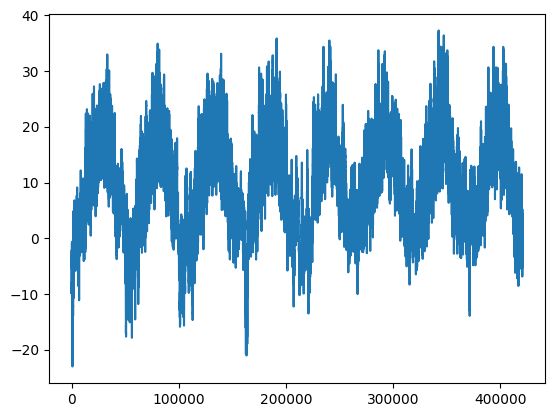

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature_data)), temperature_data)


Plotting the first 10 days of the temperature timeseries

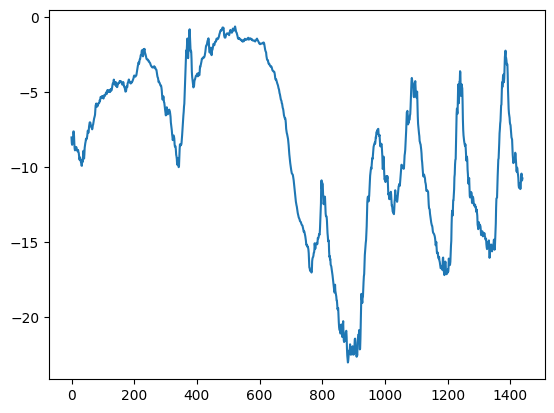

In [6]:
plt.plot(range(1440), temperature_data[:1440])


Computing the number of samples we’ll use for each data split

In [7]:
num_training_samples = int(0.5 * len(climate_data))
num_validation_samples = int(0.25 * len(climate_data))
num_testing_samples = len(climate_data) - num_training_samples - num_validation_samples
print("num_training_samples:", num_training_samples)
print("num_validation_samples:", num_validation_samples)
print("num_testing_samples:", num_testing_samples)


num_training_samples: 210225
num_validation_samples: 105112
num_testing_samples: 105114


Preparing the data

Normalizing the data

In [8]:
training_mean = climate_data[:num_training_samples].mean(axis=0)
climate_data -= training_mean
training_std = climate_data[:num_training_samples].std(axis=0)
climate_data /= training_std


In [9]:
import numpy as np
from tensorflow import keras

sequence_array = np.arange(10)
example_dataset = keras.utils.timeseries_dataset_from_array(
    data=sequence_array[:-3],
    targets=sequence_array[3:],
    sequence_length=3,
    batch_size=2,
)

for input_batch, target_batch in example_dataset:
    for i in range(input_batch.shape[0]):
        print([int(x) for x in input_batch[i]], int(target_batch[i]))


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing

In [10]:
sampling_interval = 6
sequence_len = 120
time_delay = sampling_interval * (sequence_len + 24 - 1)
batch_size_value = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    climate_data[:-time_delay],
    targets=temperature_data[time_delay:],
    sampling_rate=sampling_interval,
    sequence_length=sequence_len,
    shuffle=True,
    batch_size=batch_size_value,
    start_index=0,
    end_index=num_training_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    climate_data[:-time_delay],
    targets=temperature_data[time_delay:],
    sampling_rate=sampling_interval,
    sequence_length=sequence_len,
    shuffle=True,
    batch_size=batch_size_value,
    start_index=num_training_samples,
    end_index=num_training_samples + num_validation_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    climate_data[:-time_delay],
    targets=temperature_data[time_delay:],
    sampling_rate=sampling_interval,
    sequence_length=sequence_len,
    shuffle=True,
    batch_size=batch_size_value,
    start_index=num_training_samples + num_validation_samples
)


Inspecting the output of one of our datasets

In [11]:
for sample_batch, target_batch in train_dataset:
    print("samples shape:", sample_batch.shape)
    print("targets shape:", target_batch.shape)
    break


samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non-machine-learning baseline

Computing the common-sense baseline MAE

In [12]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.0
    samples_count = 0

    for sample_batch, target_batch in dataset:
        predictions = sample_batch[:, -1, 1] * training_std[1] + training_mean[1]
        total_absolute_error += np.sum(np.abs(predictions - target_batch))
        samples_count += sample_batch.shape[0]

    return total_absolute_error / samples_count

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


Let’s try a basic machine-learning model

Training and evaluating a densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.GlobalAveragePooling1D()(inputs)  # Using pooling instead of flatten
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 90.9008 - mae: 7.5666 - val_loss: 22.2573 - val_mae: 3.7196
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 22.5480 - mae: 3.7924 - val_loss: 20.6154 - val_mae: 3.5975
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 21.8086 - mae: 3.7342 - val_loss: 20.5042 - val_mae: 3.5770
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 21.6654 - mae: 3.7189 - val_loss: 20.6476 - val_mae: 3.5920
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 21.5305 - mae: 3.7056 - val_loss: 20.6032 - val_mae: 3.5868
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 21.4315 - mae: 3.6972 - val_loss: 20.6272 - val_mae: 3.5895
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 21.3638 - mae: 3.6909 - val_loss: 20.5308 - val_mae: 3.5759
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 21.2994 - mae: 3.6864 - val_loss: 20.6584 - val_mae: 3.5904
Epoch 9/10
819/819 ━━━━━

Plotting results

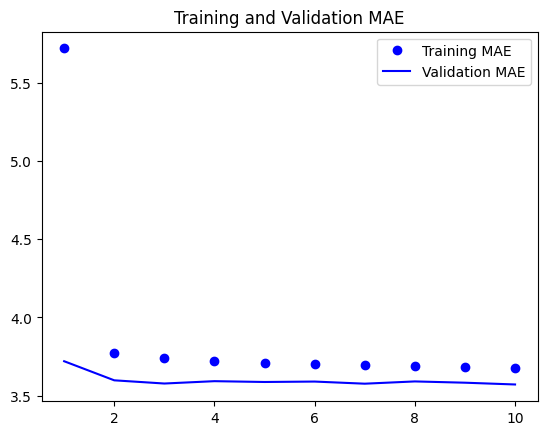

In [14]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


Let’s try a 1D convolutional model

In [15]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 31.3209 - mae: 4.3007 - val_loss: 15.9000 - val_mae: 3.1629
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 16.3048 - mae: 3.2185 - val_loss: 17.3914 - val_mae: 3.2808
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 14.3720 - mae: 3.0158 - val_loss: 14.1375 - val_mae: 2.9804
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 13.3028 - mae: 2.8901 - val_loss: 15.1533 - val_mae: 3.0728
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 12.4801 - mae: 2.7949 - val_loss: 14.8167 - val_mae: 3.0392
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 11.8657 - mae: 2.7192 - val_loss: 15.8339 - val_mae: 3.1626
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 11.3901 - mae: 2.6628 - val_loss: 19.3940 - val_mae: 3.4958
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 10.9750 - mae: 2.6121 - val_loss: 14.6884 - val_mae: 3.0230
Epoch 9/10
819/819 ━━━━━

Plotting results

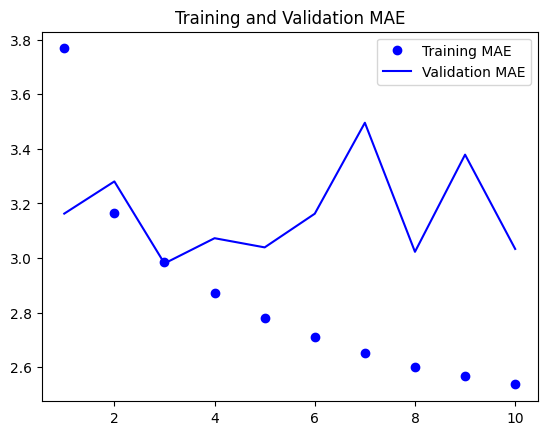

In [16]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


A first recurrent baseline

A simple LSTM-based model with Dense 16

In [17]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 73.0535 - mae: 6.5251 - val_loss: 12.8582 - val_mae: 2.7393
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 11.7866 - mae: 2.6600 - val_loss: 9.8972 - val_mae: 2.4714
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 10.0859 - mae: 2.4748 - val_loss: 9.9296 - val_mae: 2.4604
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 9.6581 - mae: 2.4167 - val_loss: 9.5413 - val_mae: 2.4200
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 9.2650 - mae: 2.3691 - val_loss: 10.4055 - val_mae: 2.4662
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 8.8279 - mae: 2.3180 - val_loss: 9.7079 - val_mae: 2.4237
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 8.5554 - mae: 2.2848 - val_loss: 9.8445 - val_mae: 2.4532
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 8.2966 - mae: 2.2517 - val_loss: 9.7810 - val_mae: 2.4528
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

Plotting results

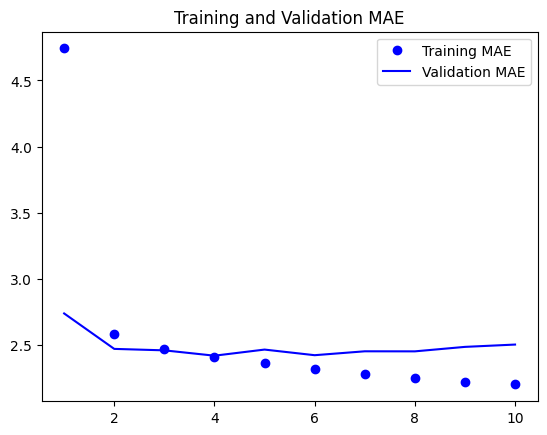

In [18]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


A simple LSTM-based model with Dense 32

In [19]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 104ms/step - loss: 44.5646 - mae: 4.8280 - val_loss: 9.9990 - val_mae: 2.4573
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 104ms/step - loss: 9.5432 - mae: 2.4000 - val_loss: 9.4104 - val_mae: 2.4008
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 113ms/step - loss: 8.5648 - mae: 2.2734 - val_loss: 9.2287 - val_mae: 2.3744
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 86s 105ms/step - loss: 8.0311 - mae: 2.1969 - val_loss: 10.0232 - val_mae: 2.4703
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 104ms/step - loss: 7.4808 - mae: 2.1209 - val_loss: 10.7069 - val_mae: 2.5490
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 90s 109ms/step - loss: 7.0936 - mae: 2.0623 - val_loss: 10.7287 - val_mae: 2.5594
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - loss: 6.7286 - mae: 2.0045 - val_loss: 11.2082 - val_mae: 2.6106
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - loss: 6.4332 - mae: 1.9582 - val_loss: 11.2214 - val_mae: 2.6120
Epoch 9/10
819/819 ━━━━━━━

Plotting results

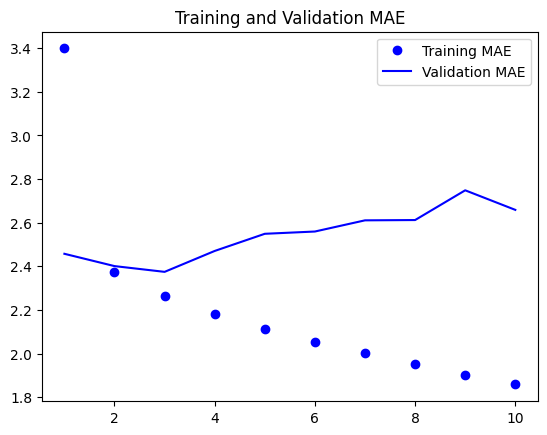

In [20]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


A simple LSTM-based model with Dense 64

In [21]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 126s 151ms/step - loss: 26.2890 - mae: 3.6228 - val_loss: 11.3701 - val_mae: 2.6624
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 115s 140ms/step - loss: 7.5865 - mae: 2.1411 - val_loss: 11.4112 - val_mae: 2.6571
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step - loss: 5.6271 - mae: 1.8248 - val_loss: 11.3399 - val_mae: 2.6447
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 134ms/step - loss: 4.5053 - mae: 1.6303 - val_loss: 12.5086 - val_mae: 2.7756
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 114s 139ms/step - loss: 3.7477 - mae: 1.4868 - val_loss: 12.5600 - val_mae: 2.7839
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 135ms/step - loss: 3.2277 - mae: 1.3842 - val_loss: 13.3487 - val_mae: 2.8560
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 114s 139ms/step - loss: 2.8112 - mae: 1.2916 - val_loss: 13.4939 - val_mae: 2.8888
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 111s 136ms/step - loss: 2.4768 - mae: 1.2142 - val_loss: 13.8289 - val_mae: 2.9038
Epoch 9/10
819/

Plotting results

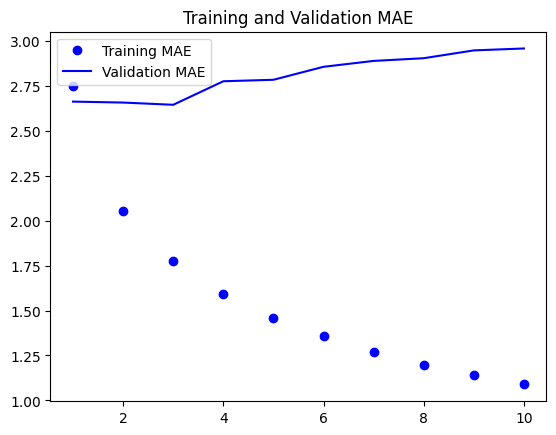

In [22]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


Understanding recurrent neural networks

NumPy implementation of a simple RNN

In [23]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

input_sequence = np.random.random((timesteps, input_features))
previous_state = np.zeros((output_features,))
weight_input = np.random.random((output_features, input_features))
weight_recurrent = np.random.random((output_features, output_features))
bias = np.random.random((output_features,))

successive_outputs = []

for current_input in input_sequence:
    output_t = np.tanh(np.dot(weight_input, current_input) + np.dot(weight_recurrent, previous_state) + bias)
    successive_outputs.append(output_t)
    previous_state = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)


A recurrent layer in Keras

An RNN layer that can process sequences of any length

In [24]:
num_features = 14
input_layer = keras.Input(shape=(None, num_features))
output_layer = layers.SimpleRNN(16)(input_layer)


An RNN layer that returns only its last output step

In [25]:
num_features = 14
sequence_length = 120
input_layer = keras.Input(shape=(sequence_length, num_features))
output_layer = layers.SimpleRNN(16, return_sequences=False)(input_layer)
print(output_layer.shape)


(None, 16)


An RNN layer that returns its full output sequence

In [26]:
num_features = 14
sequence_length = 120
input_layer = keras.Input(shape=(sequence_length, num_features))
output_layer = layers.SimpleRNN(16, return_sequences=True)(input_layer)
print(output_layer.shape)


(None, 120, 16)


Stacking RNN layers

In [27]:
input_layer = keras.Input(shape=(sequence_length, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(input_layer)
x = layers.SimpleRNN(16, return_sequences=True)(x)
output_layer = layers.SimpleRNN(16)(x)


Advanced use of recurrent neural networks

Using recurrent dropout to fight overfitting

Training and evaluating a combination of 1d_Convnet and dropout-regularized LSTM

In [28]:
input_layer = keras.Input(shape=(sequence_length, num_features))
x = layers.Conv1D(32, 5, activation="relu", padding="same")(input_layer)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1)(x)
model = keras.Model(input_layer, output_layer)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 93ms/step - loss: 27.4203 - mae: 3.8251 - val_loss: 9.2844 - val_mae: 2.3665
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - loss: 11.8698 - mae: 2.6858 - val_loss: 9.3310 - val_mae: 2.3630
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - loss: 10.9936 - mae: 2.5759 - val_loss: 9.1728 - val_mae: 2.3521
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 91ms/step - loss: 10.2571 - mae: 2.4899 - val_loss: 9.2745 - val_mae: 2.3665
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 93ms/step - loss: 9.6896 - mae: 2.4204 - val_loss: 9.7646 - val_mae: 2.4236
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 109ms/step - loss: 9.1235 - mae: 2.3477 - val_loss: 9.6405 - val_mae: 2.4172
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - loss: 8.7635 - mae: 2.2948 - val_loss: 9.9200 - val_mae: 2.4636
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - loss: 8.3498 - mae: 2.2355 - val_loss: 9.9131 - val_mae: 2.4546
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

Plotting results

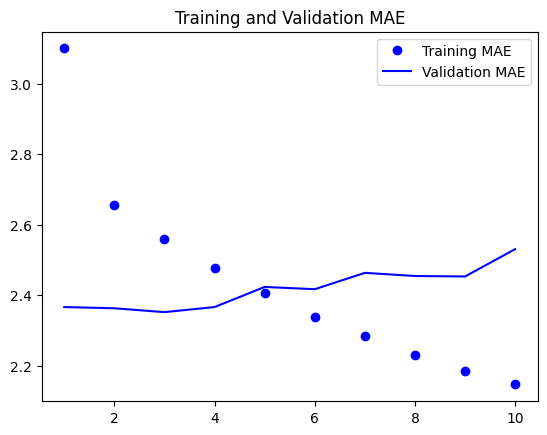

In [29]:
training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epoch_numbers = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epoch_numbers, training_mae, "bo", label="Training MAE")
plt.plot(epoch_numbers, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


In [30]:
input_shape = (sequence_length, num_features)
inputs = keras.Input(shape=input_shape)
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


Stacking recurrent layers

Training and evaluating a dropout-regularized, stacked LSTM model

In [31]:
input_shape = (sequence_length, num_features)
inputs = keras.Input(shape=input_shape)
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 276s 331ms/step - loss: 48.2689 - mae: 5.1565 - val_loss: 9.7372 - val_mae: 2.4131
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 257s 314ms/step - loss: 14.9116 - mae: 3.0046 - val_loss: 9.2806 - val_mae: 2.3574
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 263s 321ms/step - loss: 13.8369 - mae: 2.8852 - val_loss: 9.1260 - val_mae: 2.3434
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 255s 311ms/step - loss: 13.0317 - mae: 2.7997 - val_loss: 9.2103 - val_mae: 2.3572
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 255s 312ms/step - loss: 12.4292 - mae: 2.7278 - val_loss: 9.2194 - val_mae: 2.3646
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 256s 312ms/step - loss: 11.8249 - mae: 2.6646 - val_loss: 9.1013 - val_mae: 2.3508
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24237s 30s/step - loss: 11.4267 - mae: 2.6190 - val_loss: 9.2977 - val_mae: 2.3744
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 177s 216ms/step - loss: 11.1398 - mae: 2.5839 - val_loss: 9.2255 - val_mae: 2.3629
Epoch 9/10
819/8

Plotting results

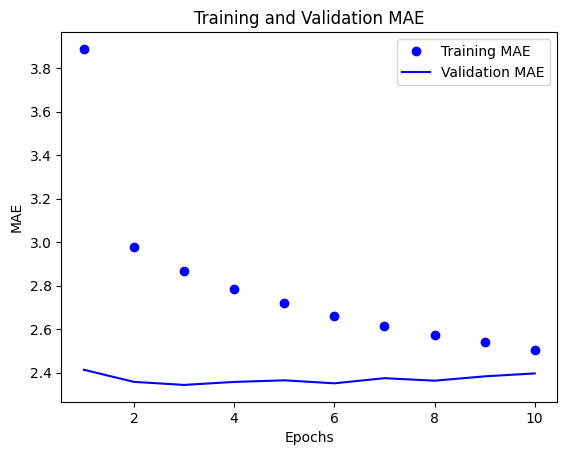

In [32]:
training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


Using bidirectional RNNs

Training and evaluating a bidirectional LSTM

In [33]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.Bidirectional(layers.LSTM(16, recurrent_dropout=0.25))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 59ms/step - loss: 52.6058 - mae: 5.3541 - val_loss: 10.3881 - val_mae: 2.4999
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - loss: 10.4139 - mae: 2.5282 - val_loss: 9.5013 - val_mae: 2.3925
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 9.5427 - mae: 2.4063 - val_loss: 9.1554 - val_mae: 2.3448
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 9.1441 - mae: 2.3544 - val_loss: 9.1965 - val_mae: 2.3412
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 79ms/step - loss: 8.7533 - mae: 2.3042 - val_loss: 9.0734 - val_mae: 2.3272
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 70s 85ms/step - loss: 8.5163 - mae: 2.2722 - val_loss: 9.0928 - val_mae: 2.3286
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step - loss: 8.3069 - mae: 2.2449 - val_loss: 9.1473 - val_mae: 2.3301
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - loss: 8.1486 - mae: 2.2261 - val_loss: 9.2708 - val_mae: 2.3481
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

Plotting results

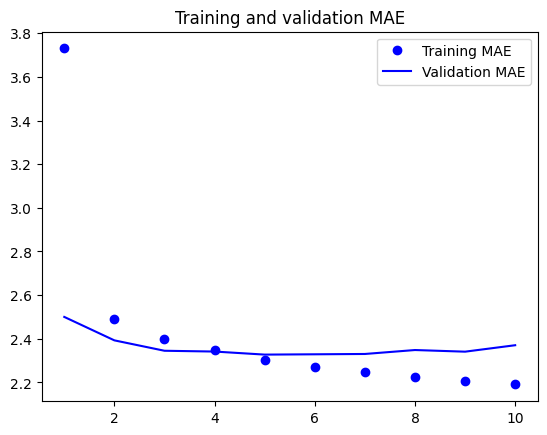

In [34]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
